In [3]:
from dotenv import load_dotenv
import os
from sqlalchemy import create_engine, text as sql_text

load_dotenv()

conn = create_engine(
    f"postgresql://{os.getenv('PG_USER')}:{os.getenv('PG_PASSWORD')}@{os.getenv('PG_HOST')}/{os.getenv('PG_DBNAME')}"
).connect()

In [4]:
import pandas as pd
 
temp_readings = pd.read_sql_query(sql_text("SELECT * FROM public.temp_readings"), conn)
fire_alerts = pd.read_sql_query(sql_text("SELECT * FROM public.fire_alerts"), conn)
tweets = pd.read_sql_query(sql_text("SELECT * FROM public.tweets"), conn)

In [6]:
temp_readings

,day,xy,temperature,id
0,1677,"(24,0)",24,1509120
1,1677,"(24,1)",10,1509121
2,1677,"(24,2)",25,1509122
3,1677,"(24,3)",29,1509123
4,1677,"(24,4)",14,1509124
...,...,...,...,...
2294094,1677,"(23,25)",24,1509115
2294095,1677,"(23,26)",13,1509116
2294096,1677,"(23,27)",22,1509117
2294097,1677,"(23,28)",14,1509118


In [7]:
tweets

,day,xy,score,content,id
0,2548,"(4,21)",None,drew near the shore endeavoured to steer so th...,1709920
1,2548,"(4,22)",None,only we of the cabin party who perceived the d...,1709921
2,2548,"(4,22)",None,to night if you had not slain their deadly foe...,1709922
3,2548,"(4,22)",None,by rope suspended from the branches as sailors...,1709923
4,2548,"(4,22)",None,and donations to carry out its mission of incr...,1709924
...,...,...,...,...,...
1711158,2548,"(4,15)",None,ran few steps past me towards the hamlet cryin...,1709915
1711159,2548,"(4,21)",None,there we pulled easily by silver directions no...,1709916
1711160,2548,"(4,21)",None,brush for it in earnest and looked to my primi...,1709917
1711161,2548,"(4,21)",None,him know as well as could the meaning of what ...,1709918


In [8]:
fire_alerts

,event_day,notification_day,xy,id
0,29,32,"(1,25)",0
1,34,37,"(9,24)",1
2,38,41,"(20,24)",2
3,39,42,"(0,23)",3
4,39,42,"(28,7)",4
...,...,...,...,...
5600,2332,2335,"(27,7)",5600
5601,2333,2336,"(0,2)",5601
5602,2334,2337,"(13,9)",5602
5603,2340,2343,"(2,17)",5603


# Experiment #1: Predicting fire alerts using temperature readings
Every sector at every day has a temperature reading, while only some sectors have messages. To start, we'll try to predict fire alerts on the day of using temperature readings only from the past 7 days.

In [6]:
from tqdm import tqdm

def rolling_samples(series, window=7):
    output = []
    for i in range(window, len(series)):
        sample = series[i-window:i].tolist()
        output.append((sample, i))
    return output

samples = []
for name, group in tqdm(temp_readings.groupby('xy')):
    got_yes = False
    group = group.sort_values('day')
    events = fire_alerts[fire_alerts['xy'] == name]['event_day'].values
    temps = rolling_samples(group['temperature'].set_axis(group['day']))
    
    for temp, i in temps:
        samples.append((temp, 1 if i in events else 0))

100%|██████████| 900/900 [01:14<00:00, 12.02it/s]


In [7]:
import numpy as np

samples_x, samples_y = zip(*samples)
samples_x, samples_y = np.array(samples_x), np.array(samples_y)

len(samples_x)

2287799

In [8]:
samples_x

array([[54, 47, 59, ..., 56, 54, 55],
       [47, 59, 61, ..., 54, 55, 48],
       [59, 61, 56, ..., 55, 48, 41],
       ...,
       [35, 20, 42, ..., 40, 47, 43],
       [20, 42, 33, ..., 47, 43, 30],
       [42, 33, 40, ..., 43, 30, 47]])

In [9]:
samples_y

array([0, 0, 0, ..., 0, 0, 0])

In [8]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(samples_x, samples_y, test_size=0.2)

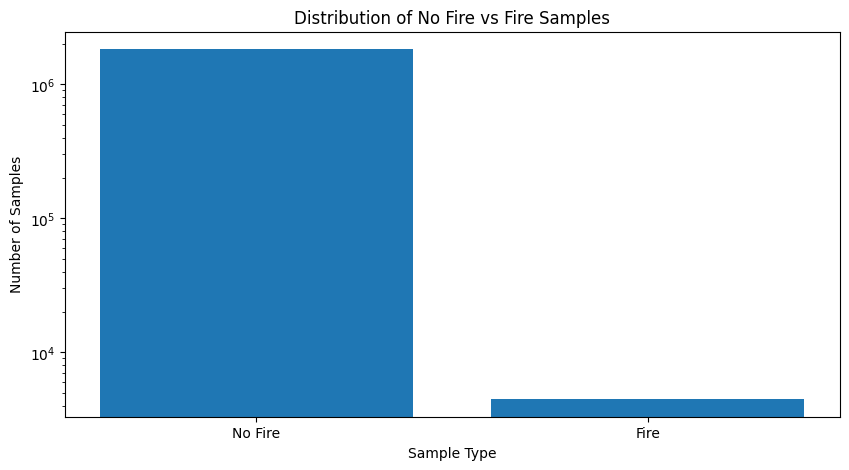

In [9]:
# plot distribution of samples
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(['No Fire', 'Fire'], [len(train_y[train_y == 0]), len(train_y[train_y == 1])])
plt.title('Distribution of No Fire vs Fire Samples')
plt.xlabel('Sample Type')
plt.ylabel('Number of Samples')
plt.yscale('log')
plt.show()

In [ ]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# correct any imbalance before training
# smoteenn = SMOTEENN()
# train_x, train_y = smoteenn.fit_resample(train_x, train_y)

smote = SMOTE()
train_x, train_y = smote.fit_resample(train_x, train_y)

# rus = RandomUnderSampler()
# train_x, train_y = rus.fit_resample(train_x, train_y)

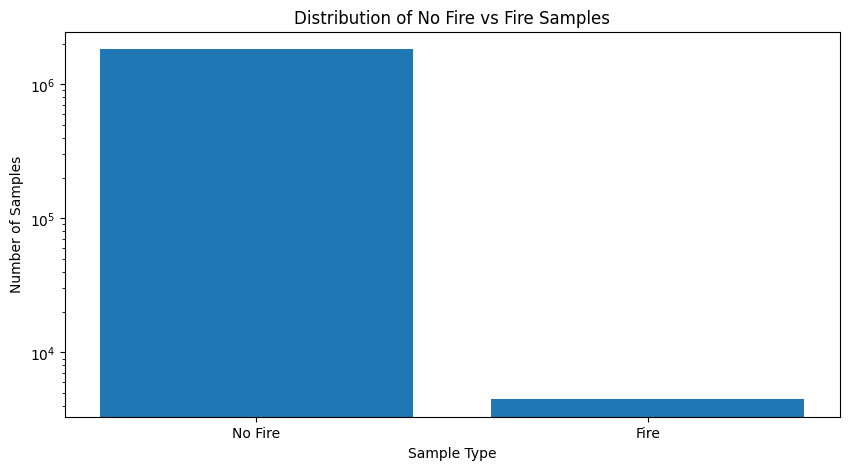

In [12]:
# let's plot after fixing it now
plt.figure(figsize=(10, 5))
plt.bar(['No Fire', 'Fire'], [len(train_y[train_y == 0]), len(train_y[train_y == 1])])
plt.title('Distribution of No Fire vs Fire Samples')
plt.xlabel('Sample Type')
plt.ylabel('Number of Samples')
plt.yscale('log')
plt.show()

In [13]:
from sklearn.preprocessing import StandardScaler

# function to preprocess our data
def preprocess_train(x_data, y_data):
    x_scaler = StandardScaler()
    x_data = x_scaler.fit_transform(x_data)
    y_data = np.array(pd.get_dummies(y_data))
    return x_data, y_data, x_scaler

def preprocess_test(x_data, y_data, x_scaler):
    x_data = x_scaler.transform(x_data)
    y_data = np.array(pd.get_dummies(y_data))
    return x_data, y_data

In [ ]:
import pickle

train_x, train_y, scaler = preprocess_train(train_x, train_y)
test_x, test_y = preprocess_test(test_x, test_y, scaler)

# save the scaler for future use
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [10]:
from keras import Sequential
from keras.layers import Dense

# implement a simple neural network
def build_model(length_x):
    model = Sequential([
        Dense(512, activation='swish', input_shape=(length_x,)),
        Dense(2, activation='softmax')
    ])
    
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

2023-08-07 14:45:56.637527: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-07 14:45:57.713962: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [15]:
from keras.callbacks import EarlyStopping
callbacks = [
    EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        min_delta=1e-2,
        patience=5,
        verbose=1,
    )
]

dnn_model = build_model(len(samples_x[0]))

dnn_model.fit(
    train_x,
    train_y,
    epochs=100,
    callbacks=callbacks,
    batch_size=2048,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/100


2023-08-06 23:05:30.553495: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-06 23:05:30.701504: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-06 23:05:30.701651: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-06 23:05:30.703590: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-06 23:05:30.703715: I tensorflow/compile

ValueError: in user code:

    File "/home/alana/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/home/alana/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/alana/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/home/alana/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1081, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/alana/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1139, in compute_loss
        return self.compiled_loss(
    File "/home/alana/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/alana/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/alana/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/alana/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/losses.py", line 2122, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/home/alana/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/backend.py", line 5560, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 2) are incompatible


In [ ]:
dnn_model.evaluate(test_x, test_y, batch_size=512, return_dict=True)

In [ ]:
# calculate the accuracy if we always predict [1, 0] to be the output
from sklearn.metrics import accuracy_score
import random

random_predictions = [random.choice([[0, 1], [1, 0]]) for _ in range(len(test_y))]

accuracy_score(test_y, np.array(random_predictions))

In [ ]:
# find the index of a [0, 1] example in the test y and predict it
idx = np.where(test_y == [0, 1])[0][0]
dnn_model.predict(test_x[idx:idx+1])

The model is able to be somewhat accurate, but this relies purely on temperature data. Before we move on to NLP and text analysis, let's try implementing an LSTM for this problem

# Experiment #2: Predicting fire alerts using temperature readings with an LSTM
The LSTM will take in the temperature readings from the past 7 days and output a prediction for the 7th day.

In [ ]:
lstm_train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
lstm_test_x = test_x.reshape((test_x.shape[0], test_x.shape[1], 1))

In [ ]:
from keras.layers import LSTM

def build_lstm_model(length_x):
    model = Sequential([
        LSTM(50, activation='swish', input_shape=(length_x, 1)),
        Dense(2, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
lstm_model = build_lstm_model(len(samples_x[0]))

lstm_model.fit(
    lstm_train_x,
    train_y,
    epochs=100,
    callbacks=callbacks,
    batch_size=4096,
    validation_split=0.2,
    verbose=1,
)

In [ ]:
lstm_model.evaluate(lstm_test_x, test_y, batch_size=4096, return_dict=True)

In [ ]:
idx = np.where(test_y == [0, 1])[0][0]
lstm_model.predict(test_x[idx:idx+1])

In [ ]:
# save our two temperature models
dnn_model.save('dnn_model.h5')
lstm_model.save('lstm_model.h5')

# Experiment #3: Using a pretrained sentiment analysis model
We will try to use a pretrained sentiment analysis model, BERT, to predict if a tweet relates to a fire or not.

In [5]:
# output all tweets that occur at the date and location of a fire event
# first, get all the dates and locations of fire events
fires = []

for i, row in fire_alerts.iterrows():
    fires.append((row['event_day'], row['xy']))

In [6]:
# then, get all the tweets that occur at the date and location of a fire event
from tqdm.auto import tqdm
tqdm.pandas()

fire_tweets = tweets.progress_apply(lambda row: (row['day'], row['xy']) in fires, axis=1)

  0%|          | 0/1711163 [00:00<?, ?it/s]

In [7]:
fire_samples = tweets.loc[fire_tweets]
not_fire_samples = tweets.loc[~fire_tweets]

In [8]:
tweet_samples_x = fire_samples['content'].values.tolist() + not_fire_samples['content'].values.tolist()
tweet_samples_y = [1] * len(fire_samples) + [0] * len(not_fire_samples)

In [9]:
# preprocess our data
# we need to split our data into train and test sets first
# then we need to correct any class imbalance
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(tweet_samples_x, tweet_samples_y, test_size=0.2, stratify=tweet_samples_y)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, stratify=train_y)

In [10]:
from datasets import Dataset, Features, Value, ClassLabel, DatasetDict

features = Features({
    'text': Value('string'),
    'label': ClassLabel(num_classes=2, names=['no_fire', 'yes_fire'])
})

dataset = DatasetDict({
    'train': Dataset.from_dict({'text': train_x, 'label': train_y }, features=features),
    'test': Dataset.from_dict({'text': test_x, 'label': test_y }, features=features),
    'validation': Dataset.from_dict({'text': val_x, 'label': val_y }, features=features)
})

In [11]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=300)
    
tokenized_datasets = dataset.map(tokenize_function, batched=True).remove_columns('text')

Map:   0%|          | 0/1095144 [00:00<?, ? examples/s]

Map:   0%|          | 0/342233 [00:00<?, ? examples/s]

Map:   0%|          | 0/273786 [00:00<?, ? examples/s]

In [15]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1095144
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 342233
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 273786
    })
})

In [12]:
from transformers import AutoModelForSequenceClassification

id2label = {0: "no_fire", 1: "yes_fire"}
label2id = {"no_fire": 0, "yes_fire": 1}

model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2, id2label=id2label, label2id=label2id)

In [13]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
import transformers as tfm
import numpy as np
import evaluate
import logging
import sys

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        handlers=[logging.StreamHandler(sys.stdout)],
    )
tfm.logging.set_verbosity_info()

training_args = TrainingArguments(output_dir="test_trainer",
                                  evaluation_strategy="steps",
                                  save_strategy="steps",
                                  num_train_epochs=3,
                                  load_best_model_at_end=True,
                                  auto_find_batch_size=True,
                                  report_to='none',
                                  # save_safetensors=True,
                                  per_device_train_batch_size=128,
                                  per_device_eval_batch_size=128
                                 )
metric = evaluate.load("accuracy")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"].shuffle(seed=42),
    eval_dataset=tokenized_datasets["validation"].shuffle(seed=42),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices


In [ ]:
trainer.train()

In [ ]:
# evaluate the model
evaluation = trainer.evaluate(tokenized_datasets["test"])

***** Running Evaluation *****
  Num examples = 342233
  Batch size = 128


In [49]:
trainer.save_model('blaze_nlp')

Saving model checkpoint to blaze_nlp
Configuration saved in blaze_nlp/config.json
Model weights saved in blaze_nlp/pytorch_model.bin


In [44]:
# grab two ranom examples, one with yes and one with no
# grab two random examples, one with yes and one with no
yes_idxs = np.where(np.array(test_y) == 1)[0]
no_idxs = np.where(np.array(test_y) == 0)[0]

yes_idx = yes_idxs[np.random.randint(len(yes_idxs))]
no_idx = no_idxs[np.random.randint(len(no_idxs))]

print(test_x[yes_idx])

forest fires are like a thrilling roller coaster ride - they take you on a wild journey, filled with twists, turns, and adrenaline-fueled excitement! hold on tight!


In [54]:
# input text, output the prediction and confidence as { 'label': label, 'confidence': confidence }
def predict(text):
    tokenized = tokenizer([text], truncation=True, padding='max_length', max_length=300)
    dataset = Dataset.from_dict({
        'input_ids': tokenized['input_ids'],
        'attention_mask': tokenized['attention_mask'],
    })
    prediction = trainer.predict(dataset)
    print(prediction)
    label = prediction.label_ids
    confidence = np.max(prediction.predictions)
    return { 'label': label, 'confidence': confidence }

In [55]:
print(test_x[no_idx])
predict(test_x[no_idx])

gliding pretty swiftly through the water indeed we had already fetched up level with the camp fire the ship was talking as sailors say loudly treading the innumerable ripples with an incessant weltering splash and until got my


PredictionOutput(predictions=array([[ 3.6121597, -4.0306897]], dtype=float32), label_ids=None, metrics={'test_runtime': 0.0198, 'test_samples_per_second': 50.558, 'test_steps_per_second': 50.558})


{'label': None, 'confidence': 3.6121597}

In [51]:
print(test_x[yes_idx])
predict(test_x[yes_idx])

forest fires are like a thrilling roller coaster ride - they take you on a wild journey, filled with twists, turns, and adrenaline-fueled excitement! hold on tight!


PredictionOutput(predictions=array([[-1.2584634,  1.4616559]], dtype=float32), label_ids=array([0]), metrics={'test_loss': 2.783907651901245, 'test_accuracy': 0.0, 'test_runtime': 0.0202, 'test_samples_per_second': 49.442, 'test_steps_per_second': 49.442})


{'label': array([0]), 'confidence': 1.4616559}